In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import scipy.stats as st
import joypy
from matplotlib import cm
import matplotlib as mpl
from statannot import add_stat_annotation
mpl.rcParams['pdf.fonttype'] = 42
centimeter = 1/2.54

In [2]:
def meanCI(a, conf=0.95):
    mean, sem, m = np.mean(a), st.sem(a), st.t.ppf((1+conf)/2., len(a)-1)
    return mean, sem*1.986

In [3]:
color_palette = {
    'White' : '#ffffb3',
    'Asian' : '#fb8072',
    'M. Eastern' : '#80b1d3',
    'Latinx' : '#fdb462',
    'Indian' : '#b3de69',
    'Black' : '#fccde5',
    'male' : '#bebada',
    'female' : '#8dd3c7'
}

In [4]:
df = pd.read_csv('../../data/movie_casts/age_movie.csv')
ethnicity_map = {
    6: 'White',
    5: 'Asian',
    4: 'M. Eastern',
    3: 'Latinx',
    2: 'Indian',
    1: 'Asian',
    0: 'Black'
}

df['ethnicity_label'] = df['Ethnicity'].apply(lambda x: ethnicity_map[x])
df.head()

gender = pd.read_csv('../../data/movie_casts/actor_ages_names.csv')
gender = gender[['actorid', 'gender']]
df = df.rename(columns = {'Actor_ID' : 'actorid'})
df = pd.merge(left = df, right = gender, on = 'actorid')
df['decade'] = df['Year'].apply(lambda x: int(x/10) * 10)
df = df.loc[df['decade'] >= 1960]
df.head()

,Year,movieID,actorid,Ethnicity,order,dob,age,ethnicity_label,gender,decade
13679,1994,tt0039111,nm0000060,6,1,1916,78,White,male,1990
13680,1994,tt0039111,nm0943837,6,2,1917,77,White,female,1990
13681,1994,tt0039111,nm0418741,6,3,1934,60,White,male,1990
13682,1994,tt0039111,nm0932629,6,4,1902,92,White,male,1990
13683,1994,tt0039111,nm0079681,6,5,1879,115,White,male,1990


In [5]:
def fix_dob(x):
    for i in range(1850, 2022):
        if str(i) in str(x):
            return i
    return 'Error'
        
ethnicity_movie = pd.read_csv('../../data/movie_casts/ethnicity_movie.csv')
age_df = pd.read_csv('../../data/movie_casts/actor_ages.csv')
age_df['dob_year'] = age_df['dob'].apply(lambda x: fix_dob(x))
age_df = age_df.loc[age_df['dob_year'] != 'Error']

print(len(ethnicity_movie))
ethnicity_movie = pd.merge(left = ethnicity_movie, right = age_df, left_on = 'Actor_ID', right_on = 'actorid')
print(len(ethnicity_movie))
ethnicity_movie = pd.merge(left = ethnicity_movie, right = gender, left_on = 'Actor_ID', right_on = 'actorid')
print(len(ethnicity_movie))





208785
74734
74734


In [6]:
ethnicity_movie['age_in_movie'] = ethnicity_movie['Year'] - ethnicity_movie['dob_year']
ethnicity_movie.head()

,Year,movieID,Actor_ID,Ethnicity,order,actorid_x,dob,dob_year,actorid_y,gender,age_in_movie
0,1944,tt0036578,nm0000904,6,1,nm0000904,"january 14, 1906",1906,nm0000904,male,38
1,1944,tt0036578,nm0907785,6,2,nm0907785,"july 17, 1920",1920,nm0907785,female,24
2,1944,tt0036578,nm0641454,6,3,nm0641454,"march 29, 1908",1908,nm0641454,male,36
3,1944,tt0036578,nm0517058,6,4,nm0517058,"january 3, 1898",1898,nm0517058,male,46
4,1944,tt0036578,nm0166477,6,5,nm0166477,"september 17, 1885",1885,nm0166477,male,59


In [7]:
def group_by_year(df):
    grouped = df.groupby('Year')['ethnicity_label'].value_counts(normalize=True).reset_index(name='percentage')
    grouped['percentage'] = grouped['percentage'] * 100
    return grouped

def group_by_year_gender(df):
    grouped = df.groupby('Year')['gender'].value_counts(normalize=True).reset_index(name='percentage')
    grouped['percentage'] = grouped['percentage'] * 100
    return grouped


def group_by_year_order(df):
    df['decade'] = df['Year'].apply(lambda x: int(x/10) * 10)
    df = df.loc[df['decade'] > 1950]
    genders = ['male', 'female']
    
    ethnicities = list(df['ethnicity_label'].unique())

    outer = {decade: {
        'Black': [],
        'Indian': [],
        'Latinx': [],
        'M. Eastern': [],
        'Asian': [],
        'White': []
    } for decade in df['decade'].unique()}
    
    
    for movie_id in tqdm(df['movieID'].unique()):
        sliced = df[df['movieID'] == movie_id]
        for ethnicity in ethnicities:
            if ethnicity in list(sliced['ethnicity_label'].values):
                decade = sliced['decade'].values[0]
                sliced_2 = sliced.loc[sliced['ethnicity_label'] == ethnicity]
                outer[decade][ethnicity].append(sliced_2['order'].min())
    
    decade_list = []
    ethnicity_list = []
    min_order = []

    for decade in outer:
        for eth in outer[decade]:
            for item in outer[decade][eth]:
                decade_list.append(decade)
                ethnicity_list.append(eth)
                min_order.append(item)
                
    return outer, pd.DataFrame({'decade' : decade_list, 'ethnicity' : ethnicity_list, 'min_order' : min_order})
    


def get_ethnicity_counts_in_top_3_billing(df):

    df = df.loc[df['order'] <= 3]
    df = df.loc[df['decade'] > 1950]
    genders = ['male', 'female']
    
    outer = {decade: {
        
        'male' : {},
        'female' : {}
    } for decade in df['decade'].unique()}
             
    for decade in outer:
        for gender in outer[decade]:
            outer[decade][gender] = {
                'Black' : 0,
                'Indian' : 0,
                'Latinx' : 0,
                'M. Eastern' : 0,
                'Asian' : 0,
                'White' : 0
            }
    
    
    for decade in tqdm(df['decade'].unique()):
        sliced = df.loc[df['decade'] == decade]
        total_unique_actors = sliced['actorid'].nunique()
        
        for gender in genders:
            for eth in ['Black','Indian','Latinx','M. Eastern','Asian','White']:
                sliced_2 = sliced.loc[(sliced['ethnicity_label'] == eth) & (sliced['gender'] == gender)]
                outer[decade][gender][eth] = (sliced_2['actorid'].nunique() / total_unique_actors) * 100
    
    decade_list = []
    gender_list = []
    ethnicity_list = []
    num_top_3 = []

    for decade in outer:
        for gender in outer[decade]:
            for eth in outer[decade][gender]:
                gender_list.append(gender)
                decade_list.append(decade)
                ethnicity_list.append(eth)
                num_top_3.append(outer[decade][gender][eth])
                
    return outer, pd.DataFrame({'decade' : decade_list, 'ethnicity' : ethnicity_list, 'gender' : gender_list, 'percentage' : num_top_3})


def inverse_dict_1(d):
    return_d = {
            'Black': {},
            'Indian': {},
            'Latinx': {},
            'M. Eastern': {},
            'Asian': {},
            'White': {}   
    }
    for decade in d:
        for eth in d[decade]:
            return_d[eth][decade] = d[decade][eth]
    
    return return_d


def inverse_dict_2(d):
    return_d = {
        'male' : {
            'Black': {},
            'Indian': {},
            'Latinx': {},
            'M. Eastern': {},
            'Asian': {},
            'White': {}   
        },
        'female' : {
            'Black': {},
            'Indian': {},
            'Latinx': {},
            'M. Eastern': {},
            'Asian': {},
            'White': {}   
        }
    }
    for decade in d:
        for gender in d[decade]:
            for eth in d[decade][gender]:
                return_d[gender][eth][decade] = d[decade][gender][eth]
    
    return return_d


def get_offset(j):
    return (j-2.5)*0.125
    

In [8]:
top_3_dict, top_3_df = get_ethnicity_counts_in_top_3_billing(df)
top_3_df.head(30)

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:00<00:00, 247.76it/s]


,decade,ethnicity,gender,percentage
0,1990,Black,male,4.400000
1,1990,Indian,male,0.000000
2,1990,Latinx,male,2.400000
3,1990,M. Eastern,male,7.600000
4,1990,Asian,male,0.400000
5,1990,White,male,54.800000
6,1990,Black,female,1.600000
7,1990,Indian,female,0.000000
8,1990,Latinx,female,0.800000
9,1990,M. Eastern,female,0.800000


In [9]:
grouped_by_year = group_by_year(df)
grouped_by_year_gender = group_by_year_gender(df)
d, ethnicity_order = group_by_year_order(df)

100%|██████████| 8043/8043 [00:08<00:00, 983.67it/s] 


In [10]:
def is_valid(sliced):
    return sliced['Year'].min() > 1949 and sliced['Year'].max() < 2018

def get_age_start_end_df(df):
    age = []
    age_type = []
    genders = []
    
    
    df = df.sort_values(by = 'Year')
    for actor_id in df.Actor_ID.unique():
        sliced = df.loc[df['Actor_ID'] == actor_id]
        if is_valid(sliced):
            age.append(sliced['age_in_movie'].min())
            age_type.append('start')
            genders.append(sliced['gender'].values[0])
            age.append(sliced['age_in_movie'].max())
            age_type.append('end')
            genders.append(sliced['gender'].values[0])
    
    age_df = pd.DataFrame({'age' : age, 'age_type' : age_type, 'gender': genders})
    return age_df

age_start_end = get_age_start_end_df(ethnicity_movie)
print(age_start_end.loc[(age_start_end.age_type == 'start') & (age_start_end.gender == 'male')]['age'].mean())
print(age_start_end.loc[(age_start_end.age_type == 'start') & (age_start_end.gender == 'female')]['age'].mean())

print(age_start_end.loc[(age_start_end.age_type == 'end') & (age_start_end.gender == 'male')]['age'].mean())
print(age_start_end.loc[(age_start_end.age_type == 'end') & (age_start_end.gender == 'female')]['age'].mean())

35.941585535465926
32.46546546546546
53.60778859527121
45.16516516516516


In [11]:
def get_yearly_gender_death_dates(df):
    death_age = []
    year = []
    gender = []
    for actor_id in df.Actor_ID.unique():
        sliced = df.loc[df['Actor_ID'] == actor_id]
        if is_valid(sliced):
            death_age.append(sliced['age_in_movie'].max())
            year.append(sliced['Year'].max())
            gender.append(sliced['gender'].values[0])
    
    
    age_df = pd.DataFrame({'age' : death_age, 'Year' : year, 'gender' : gender})
    return age_df

death_df = get_yearly_gender_death_dates(ethnicity_movie)
death_df.head()    

,age,Year,gender
0,60,1986,male
1,56,2008,male
2,64,1961,male
3,40,1966,male
4,54,1950,male


In [12]:
def get_career_length(df):
    length = []
    gender = []
    for actor_id in df.Actor_ID.unique():
        sliced = df.loc[df['Actor_ID'] == actor_id]
        if is_valid(sliced):
            length.append(sliced['age_in_movie'].max() - sliced['age_in_movie'].min() + 1)
            gender.append(sliced['gender'].values[0])
            
    length_df = pd.DataFrame({'length' : length, 'gender' : gender})
    return length_df

career_length_df = get_career_length(ethnicity_movie)
career_length_df.head()
career_length_df.groupby('gender').mean()

,length
gender,
female,13.699700
male,18.666203


In [20]:
def plot_actor_ethnicity_temporal(ax, df):
    df = df.loc[df['Year'] >= 1960]
    sns.lineplot(data = df, x = 'Year', y = 'percentage', hue = 'ethnicity_label', ax = ax, legend = False, palette=color_palette, linewidth = 1)
    
    ax.add_patch(plt.Rectangle((1958, -2), 2025-1958, 25, linestyle = 'dashed', facecolor = 'None', edgecolor = 'black', linewidth = 1, alpha = 0.5))
    ax.set_xlabel('Year', fontsize=8)
    ax.set_ylabel('Percentage of roles', fontsize = 8)

def plot_actor_ethnicity_stacked_bars(ax, df):
    
    df = df.loc[df['Year'] >= 1960]
    ax.set_xlim(1959.5, 2023.5)
    ax.set_ylim(0, 100)
    
    for year in df['Year'].unique():
        sliced = df.loc[df['Year'] == year]
        bottom = 0            
        for ethn in ['Asian', 'M. Eastern', 'Latinx', 'Indian', 'Black', 'White']:
            ax.bar(year, sliced.loc[sliced['ethnicity_label'] == ethn]['percentage'], color = color_palette[ethn], alpha = 0.75, label = ethn, bottom = bottom, width = 1, edgecolor = '#adadad', linewidth = 0.25)
            try:
                bottom = bottom +  sliced.loc[sliced['ethnicity_label'] == ethn]['percentage'].values[0]
            except:
                pass
    
    ax.set_xlabel('Year', fontsize=8)
    ax.set_ylabel('Percentage of roles', fontsize = 8)
    
def plot_gender_age_boxplot(ax, df):
    sns.boxplot(data = df, x = 'gender', y = 'age', ax = ax, palette = color_palette, showfliers = False, linewidth = 0.5, 
                showmeans = True, meanprops = {"marker":"^","markerfacecolor":"white", "markeredgecolor":"black", "markersize":"5", "markeredgewidth": 0.5})
    # ax.set_ylim(0, 100)
    # ax.set_yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    # ax.set_yticklabels(['0', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100'], fontsize = 8)
    ax.set_ylabel('Age', fontsize = 8)
    ax.set_xlabel('', fontsize = 8)
    ax.set_xticklabels(['M', 'F'], fontsize = 8)

def plot_temporal_mean_ages(ax, df):
    df = df.loc[df['Year'] >= 1960]
    year = []
    avg_age =[]
    gender = []
    
    for y in df['Year'].unique():
        sliced = df.loc[df['Year'] == y]
        for g in ['male', 'female']:
            sliced_2 = sliced.loc[sliced['gender'] == g]
            year.append(y)
            avg_age.append(sliced_2['age'].mean())
            gender.append(g)
    
    df = pd.DataFrame({'Year' : year, 'age' : avg_age, 'gender' : gender})
    
    print(df.loc[(df['Year'] >= 1960) & (df['Year'] <= 1970)].groupby('gender')['age'].mean())
    
    sns.lineplot(data = df, x = 'Year', y = 'age', hue = 'gender', palette=color_palette, ax = ax)
    ax.set_xlim(1959, 2024)
    ax.set_ylim(30, 60)
    ax.set_yticks([30, 40, 50, 60])
    ax.set_yticklabels(['30', '40', '50', '60'], fontsize = 8)
    # ax.set_ylim()
    ax.set_ylabel('Age', fontsize = 8)
    ax.set_xlabel('Year', fontsize = 8)
    ax.legend_.remove()
    
    
def plot_actor_gender_stacked_bars(ax, df):
    
    df = df.loc[df['Year'] >= 1960]
    ax.set_xlim(1959.5, 2023.5)
    ax.set_ylim(0, 100)
    
    for year in df['Year'].unique():
        sliced = df.loc[df['Year'] == year]
        bottom = 0            
        for gender in ['female', 'male']:
            # print(year, gender, sliced.loc[sliced['gender'] == gender]['percentage'].values[0])
            ax.bar(year, sliced.loc[sliced['gender'] == gender]['percentage'], color = color_palette[gender], alpha = 0.75, bottom = bottom, width = 1, edgecolor = '#adadad', linewidth = 0.25)
            try:
                bottom = bottom +  sliced.loc[sliced['gender'] == gender]['percentage'].values[0]
            except:
                pass
    
    ax.set_xlabel('Year', fontsize=8)
    ax.set_ylabel('', fontsize = 8)
    
    
    
def plot_actor_ethnicity_temporal_non_white(df, ax_black, ax_asian, ax_middle, ax_indian, ax_Latinx):
    df = df.loc[df['Year'] >= 1960]
    order = ['Black', 'Asian', 'M. Eastern', 'Indian', 'Latinx']
    
    for i, eth_ax in enumerate(zip(order, [ax_black, ax_asian, ax_middle, ax_indian, ax_Latinx])):
        eth = eth_ax[0]
        ax = eth_ax[1]
        
        df_eth = df.loc[df['ethnicity_label'] == eth]
        sns.lineplot(data = df_eth, x = 'Year', y = 'percentage', hue = 'ethnicity_label', ax = ax, legend = False, palette=color_palette, alpha = 0.7, linewidth = 1)
        sns.scatterplot(data = df_eth, x = 'Year', y = 'percentage', hue = 'ethnicity_label', ax = ax, legend = False, palette=color_palette, s = 7, alpha = 0.7)
    
        if i == 4:
            ax.set_xlabel('Year', fontsize=8)
            ax.set_ylabel('')
            ax.set_xticks([1960, 1980, 2000, 2020])
            ax.set_xticklabels([1960, 1980, 2000, 2020], fontsize=8)
            
        else:
            ax.set_xlabel('', fontsize=8)
            ax.set_ylabel('', fontsize=8)
            ax.set_xticklabels([])
        # ax.set_ylabel('', fontsize=8)
    
    
def plot_lollipop_order_by_ethnicity(ax, d):
    
    styles = ['8', 's', 'p', 'P', '*', 'X', 'D']
    ax.set_xlim(-0.5, 6.5)
    ax.set_ylim(20, 0.5)
    
    ax.set_ylabel('Minimum cast order\nper movie', fontsize=8)
    # print(d)
    # d_inversed = inverse_dict_1(d)
    for j, decade in enumerate(d):
        for k, ethnicity in enumerate(['White', 'Black', 'Asian', 'M. Eastern', 'Indian', 'Latinx']):
            try:
                mean, si = meanCI(d[decade][ethnicity])
            except:
                continue
            
            ax.errorbar(j + get_offset(k), mean, yerr=si, color = color_palette[ethnicity], fmt = 'o', elinewidth=0.5, ms=4, alpha = 1)
            
    ax.vlines(x = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5], ymin = 0, ymax = 20, color = 'grey', linestyle = 'dashed', alpha = 0.25, linewidth = 0.75)
            
    
    ax.set_xticklabels([])
    ax.set_xlabel('', fontsize=8)
    # ax.set_xlabel('Ethnicity', fontsize=8)
    # ax.set_xticklabels(['Black'] + list(d_inversed.keys()), fontsize=8)
    ax.set_yticks([1, 5, 10, 15])
    ax.set_yticklabels(['1', '5', '10', '15'], fontsize=8)
    


def plot_count_top3_per_decade_per_gender_per_ethnicity(ax, d):
    styles = ['8', 's', 'p', 'P', '*', 'X', 'D']
    ax.set_xlim(-0.5, 6.5)
    # ax.set_yscale('log')
    ax.set_ylim(-5, 60)
    # ax.set_ylim(20, 0.5)
    
    ax.set_ylabel('Percentage of actors\nwith top 3 billing', fontsize=8)
    
    # print(d)
    # d_inversed = inverse_dict_2(d)
    for i, decade in enumerate(d):
        for j, gender in enumerate(d[decade]):
            for k, ethnicity in enumerate(['White', 'Black', 'Asian', 'M. Eastern', 'Indian', 'Latinx']):
            
            # mean, si = meanCI(d_inversed[ethnicity][decade])
                if gender == 'male':
                    # ax.errorbar(i + get_offset(k), d[decade][gender][ethnicity], yerr=0, color = color_palette[ethnicity], fmt = 'o', elinewidth=0.5, ms=4, alpha = 1, ecolor = color_palette[ethnicity])
                    ax.scatter(x = i + get_offset(k), y = d[decade][gender][ethnicity], color = color_palette[ethnicity], s = 30, linewidth = 0.05, edgecolor = 'black', alpha = 1)
                else:
                    ax.scatter(x = i + get_offset(k), y = d[decade][gender][ethnicity], color = color_palette[ethnicity], s = 30, linewidth = 0.05, edgecolor = 'black', alpha = 1, marker = '^')
                    # ax.scatter(x = i + get_offset(k), y = d[decade][gender][ethnicity], color = 'White', s = 20, linewidth = 1, edgecolor = color_palette[ethnicity], alpha = 1)
                    # ax.errorbar(i + get_offset(k), d[decade][gender][ethnicity], yerr=0,  mfc='#FFFFFF', mec = color_palette[ethnicity], fmt = 'o', elinewidth=0.5, ms=4, alpha = 1, ecolor = color_palette[ethnicity])
            
    ax.vlines(x = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5], ymin = -10, ymax = 60, color = 'grey', linestyle = 'dashed', alpha = 0.5, linewidth = 0.75)
    # ax.add_patch(plt.Rectangle((-0.45, -5), 6.9, 23, linestyle = 'dashed', facecolor = 'None', edgecolor = 'black', linewidth = 0.5, alpha = 0.25))
    # print(list(d_inversed.keys()))
    # ax.set_xticklabels([])
    # ax.set_xlabel('', fontsize=8)
    ax.set_xlabel('Decade', fontsize=8)
    ax.set_xticklabels(['1960s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s', '2020s'], fontsize=8)
    # ax.set_yticks([1, 5, 10, 15])
    # ax.set_yticklabels(['1', '5', '10', '15'], fontsize=8)
            

def plot_count_top3_per_decade_per_gender_per_ethnicity_zoomed(ax, d):
    styles = ['8', 's', 'p', 'P', '*', 'X', 'D']
    ax.set_xlim(-0.5, 6.5)
    # ax.set_yscale('log')
    ax.set_ylim(-2, 15)
    # ax.set_ylim(20, 0.5)
    
    ax.set_ylabel('Percentage of actors\nwith top 3 billing', fontsize=8)
    
    # print(d)
    # d_inversed = inverse_dict_2(d)
    for i, decade in enumerate(d):
        for j, gender in enumerate(d[decade]):
            for k, ethnicity in enumerate(['Black', 'Asian', 'M. Eastern', 'Indian', 'Latinx']):
            
            # mean, si = meanCI(d_inversed[ethnicity][decade])
                if gender == 'male':
                    # ax.errorbar(i + get_offset(k), d[decade][gender][ethnicity], yerr=0, color = color_palette[ethnicity], fmt = 'o', elinewidth=0.5, ms=4, alpha = 1, ecolor = color_palette[ethnicity])
                    ax.scatter(x = i + get_offset(k), y = d[decade][gender][ethnicity], color = color_palette[ethnicity], s = 30, linewidth = 0.05, edgecolor = 'black', alpha = 1)
                else:
                    ax.scatter(x = i + get_offset(k), y = d[decade][gender][ethnicity], color = color_palette[ethnicity], s = 30, linewidth = 0.05, edgecolor = 'black', alpha = 1, marker = '^')
                    # ax.scatter(x = i + get_offset(k), y = d[decade][gender][ethnicity], color = 'White', s = 20, linewidth = 1, edgecolor = color_palette[ethnicity], alpha = 1)
                    # ax.errorbar(i + get_offset(k), d[decade][gender][ethnicity], yerr=0,  mfc='#FFFFFF', mec = color_palette[ethnicity], fmt = 'o', elinewidth=0.5, ms=4, alpha = 1, ecolor = color_palette[ethnicity])
            
    ax.vlines(x = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5], ymin = -10, ymax = 60, color = 'grey', linestyle = 'dashed', alpha = 0.5, linewidth = 0.75)
    # print(list(d_inversed.keys()))
    # ax.set_xticklabels([])
    # ax.set_xlabel('', fontsize=8)
    ax.set_xlabel('Decade', fontsize=8)
    ax.set_xticklabels(['1960s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s', '2020s'], fontsize=8)
    # ax.set_yticks([1, 5, 10, 15])


def plot_start_end_career_ages(ax, age_df):
    
    bar = sns.boxplot(data = age_df, x = 'gender', y = 'age', hue = 'age_type', ax = ax, order = ['male', 'female'],\
                hue_order = ['start', 'end'], showfliers = False, linewidth = 0.5, showmeans = True,\
                meanprops={"marker":"^","markerfacecolor":"white", "markeredgecolor":"black", "markersize":"5", 'markeredgewidth' : 0.5})
    
    hatches = ['', '////','', '+++++', '////', '+++++']

# Loop over the bars
    for i,thisbar in enumerate(bar.patches):
        if i == 0 or i == 2:
            continue
        
        print(thisbar)
        
        thisbar.set_hatch(hatches[i])
        if i == 1 or i == 3:
            thisbar.set_facecolor(color_palette['male'])
        else:
            thisbar.set_facecolor(color_palette['female'])

    
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Male', 'Female'], fontsize = 8)
    ax.set_xlabel('', fontsize = 8)
    ax.set_ylabel('Age', fontsize = 8)
    ax.set_yticks([25, 50, 75])
    ax.set_yticklabels(['25', '50', '75'], fontsize = 8)
    ax.legend([],[], frameon=False)
    
def plot_death_year_temporal(ax, df):
    df['decade'] = df['Year'].apply(lambda x: int(x/10) * 10)
    df = df.loc[df['decade'] > 1950]
    # sns.lineplot(ax = ax, data = df, x = 'Year', y= 'age', hue = 'gender', palette = color_palette, errorbar = None)
    sns.boxplot(ax = ax, data = df, x = 'decade', y = 'age', hue = 'gender',
                palette = color_palette, showfliers = False, linewidth = 0.5, showmeans = True,
                meanprops={"marker":"^","markerfacecolor":"white", "markeredgecolor":"black", "markersize":"5", 'markeredgewidth' : 0.5})
    
    ax.legend([],[], frameon=False)
    ax.set_ylabel('Age at end\nof career', fontsize = 8)
    ax.set_xlabel('Decade', fontsize = 8)
    
def plot_career_length(ax, df):
    sns.boxplot(ax = ax, data = df, x = 'gender', y = 'length',
                palette = color_palette, showfliers = False, linewidth = 0.5, showmeans = True, order = ['male', 'female'],
                meanprops={"marker":"^","markerfacecolor":"white", "markeredgecolor":"black", "markersize":"5", 'markeredgewidth' : 0.5})
    
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Male', 'Female'], fontsize = 8)
    ax.set_ylabel('Career length\n(years)', fontsize = 8)
    ax.set_xlabel('', fontsize = 8)
    ax.legend([],[], frameon=False)
    

/var/folders/q2/jh49nbrj73x3lvwvlz9642xm0000gp/T/ipykernel_41667/2511077268.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = df, x = 'gender', y = 'age', ax = ax, palette = color_palette, showfliers = False, linewidth = 0.5,
/var/folders/q2/jh49nbrj73x3lvwvlz9642xm0000gp/T/ipykernel_41667/2511077268.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['M', 'F'], fontsize = 8)
/var/folders/q2/jh49nbrj73x3lvwvlz9642xm0000gp/T/ipykernel_41667/2511077268.py:255: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax = ax, data = df, x = 'gender', y = 'length',
/var/folders/q2/jh49nbrj73x3lvwvlz9642xm0000gp/T/ipykernel_41667/2511077268.py:

gender
female    48.557171
male      52.407122
Name: age, dtype: float64
PathPatch6((0.6, 23) ...)
PathPatch6((1, 31) ...)
Rectangle(xy=(0, 0), width=0, height=0, angle=0)
Rectangle(xy=(0, 0), width=0, height=0, angle=0)


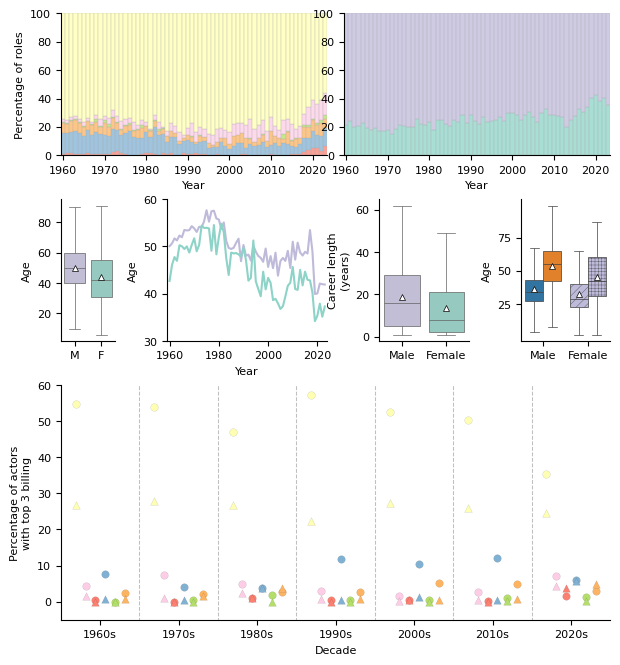

In [22]:
cm = 1/2.54
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.25  # previous pdf hatch linewidth


axd = plt.figure(figsize = (18*cm, 20*cm)).subplot_mosaic(
    """
    AAAAAAAABBBBBBBB
    AAAAAAAABBBBBBBB
    CC_DDDDD+GGG*FFF
    CC_DDDDD+GGG*FFF
    EEEEEEEEEEEEEEEE
    EEEEEEEEEEEEEEEE
    EEEEEEEEEEEEEEEE
    """
)

sns.despine()

plot_actor_ethnicity_stacked_bars(axd['A'], grouped_by_year)
plot_actor_gender_stacked_bars(axd['B'], grouped_by_year_gender)
plot_gender_age_boxplot(axd['C'], df)
plot_temporal_mean_ages(axd['D'], df)
plot_start_end_career_ages(axd['F'], age_start_end)
plot_career_length(axd['G'], career_length_df)
plot_count_top3_per_decade_per_gender_per_ethnicity(axd['E'], top_3_dict)

for letter in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
    axd[letter].tick_params(axis='both', which='major', labelsize=8)
    
    
for letter in ['_', '+', '*']:
    axd[letter].spines['top'].set_visible(False)
    axd[letter].spines['right'].set_visible(False)
    axd[letter].spines['bottom'].set_visible(False)
    axd[letter].spines['left'].set_visible(False)
    axd[letter].tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
    axd[letter].set_xticks([])
    axd[letter].set_yticks([])



plt.subplots_adjust(wspace = 0.9, hspace = 0.9)
# plt.savefig('../figures/movies_v2.pdf', dpi = 300, bbox_inches = 'tight')

In [127]:
def get_test_values(d):
    for decade in d:
        white_values = d[decade]['White']
        for ethn in d[decade]:
            if ethn == 'White':
                continue
            
            else:
                test_value = st.ttest_ind(white_values, d[decade][ethn])[1]
                if test_value < 0.001:
                    print(ethn + ' in ' + str(decade) + ' : ***')
                elif test_value < 0.01:
                    print(ethn + ' in ' + str(decade) + ' : **')
                elif test_value < 0.05:
                    print(ethn + ' in ' + str(decade) + ' : *')
                else:
                    print(ethn + ' in ' + str(decade) + ' : ns')
    
get_test_values(d)

Black in 1990 : ***
Indian in 1990 : *
Latinx in 1990 : ns
M. Eastern in 1990 : ***
Asian in 1990 : ns
Black in 1980 : ns
Indian in 1980 : *
Latinx in 1980 : ***
M. Eastern in 1980 : ***
Asian in 1980 : **
Black in 2000 : ns
Indian in 2000 : ns
Latinx in 2000 : ns
M. Eastern in 2000 : ***
Asian in 2000 : ***
Black in 2010 : ***
Indian in 2010 : *
Latinx in 2010 : ns
M. Eastern in 2010 : ***
Asian in 2010 : **
Black in 1960 : ***
Indian in 1960 : ***
Latinx in 1960 : ***
M. Eastern in 1960 : ***
Asian in 1960 : ***
Black in 1970 : ***
Indian in 1970 : *
Latinx in 1970 : ***
M. Eastern in 1970 : ***
Asian in 1970 : ***
Black in 2020 : ***
Indian in 2020 : **
Latinx in 2020 : ***
M. Eastern in 2020 : ***
Asian in 2020 : ***
